In [1]:
import os
from os.path import exists

import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
from dmelon.utils import check_folder

In [2]:
DATA_PATH = "../data/"
ROOT_PATH = "/data/users/service/IGP-UHM"

# GODAS preprocessing

Firs we load and combine the GODAS raw data downloaded from https://downloads.psl.noaa.gov/Datasets/godas/

We need to also substract 273.15 since we are reading potential temperature values in K.

In [3]:
GODAS_DATA = (
    xr.open_mfdataset(os.path.join(DATA_PATH, "raw", "GODAS", "pottmp.*.nc")).pottmp
    - 273.15
)
GODAS_DATA

<xarray.DataArray 'pottmp' (time: 522, level: 40, lat: 418, lon: 360)>
dask.array<sub, shape=(522, 40, 418, 360), dtype=float32, chunksize=(12, 40, 418, 360), chunktype=numpy.ndarray>
Coordinates:
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -74.5 -74.17 -73.83 -73.5 ... 63.5 63.83 64.17 64.5
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-06-01

## Regrid with xESMF

We need set every datased that will be fed to the convolutional neural network on the same grid. To do so, we use the conservative normed method for regridding provided by xESMF. A common problem with downsampling climate data with land masked is the propagation of `nan` values along the coaslines, so in order to avoid this, we manually define a mask variable with the current and expected land mask in the input and output grids, respectively.

In [5]:
SOURCE_GRID_PATH = os.path.join(DATA_PATH, "processed", "godas.source.grid.418x360.nc")
check_folder(os.path.dirname(SOURCE_GRID_PATH))

source_grid = xr.Dataset(
    {
        "lat": (["lat"], GODAS_DATA.lat.data),
        "lon": (["lon"], GODAS_DATA.lon.data),
    }
)
source_grid["mask"] = xr.where(
    ~np.isnan(GODAS_DATA.isel(time=0, level=0, drop=True).load()), 1, 0
)
source_grid.to_netcdf(SOURCE_GRID_PATH)
source_grid

<xarray.Dataset>
Dimensions:  (lat: 418, lon: 360)
Coordinates:
  * lat      (lat) float32 -74.5 -74.17 -73.83 -73.5 ... 63.5 63.83 64.17 64.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    mask     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1

sanity check of land mask

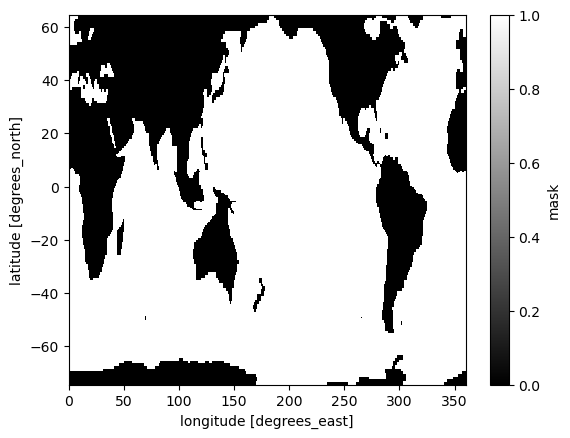

In [6]:
source_grid.mask.plot(cmap="binary_r")

Here we define the output grid

In [7]:
TARGET_GRID_PATH = os.path.join(DATA_PATH, "processed", "model.target.grid.24x72.nc")
check_folder(os.path.dirname(TARGET_GRID_PATH))

target_grid = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-57.5, 60, 5)),
        "lon": (["lon"], np.arange(2.5, 360, 5)),
    }
)
target_grid.to_netcdf(TARGET_GRID_PATH)
target_grid

<xarray.Dataset>
Dimensions:  (lat: 24, lon: 72)
Coordinates:
  * lat      (lat) float64 -57.5 -52.5 -47.5 -42.5 -37.5 ... 42.5 47.5 52.5 57.5
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
Data variables:
    *empty*

Create the regridder object with the input and output grids and save it as netcdf to save recomputing the weights every time we run the notebook.

In [8]:
REGRIDDER_PATH = os.path.join(DATA_PATH, "processed", "godas.regridder.nc")
check_folder(os.path.dirname(REGRIDDER_PATH))

regridder = xe.Regridder(
    source_grid,
    target_grid,
    "conservative_normed",
)
target_grid.close()
regridder.to_netcdf(REGRIDDER_PATH)
regridder

xESMF Regridder 
Regridding algorithm:       conservative_normed 
Weight filename:            conservative_normed_418x360_24x72.nc 
Reuse pre-computed weights? False 
Input grid shape:           (418, 360) 
Output grid shape:          (24, 72) 
Periodic in longitude?      False

In [9]:
def clim(data: xr.DataArray, time_sel: slice) -> xr.DataArray:
    return data.sel(time=time_sel).groupby("time.month").mean(dim="time")

Regrid the whole GODAS dataset

In [10]:
GODAS_DATA_regrid = regridder(GODAS_DATA).load().interpolate_na(dim="time")
GODAS_DATA_regrid = GODAS_DATA_regrid.where(GODAS_DATA_regrid != 0)
GODAS_DATA_regrid

<xarray.DataArray (time: 523, level: 40, lat: 24, lon: 72)>
array([[[[ 2.417405  ,  2.3570218 ,  2.355666  , ...,  2.6492581 ,
           2.5446472 ,  2.4906807 ],
         [ 4.193102  ,  4.2230625 ,  3.9755602 , ...,  4.420084  ,
           3.9441469 ,  4.110822  ],
         [ 7.987892  ,  7.848639  ,  7.4839892 , ...,  7.6761394 ,
           8.049223  ,  8.19949   ],
         ...,
         [        nan,         nan,         nan, ..., 12.061181  ,
          11.754012  , 11.982759  ],
         [ 6.4086814 ,  6.166671  ,  4.8964896 , ..., 10.378261  ,
          10.231737  ,         nan],
         [ 6.527694  ,  5.3949156 ,  4.625723  , ...,  9.167377  ,
           9.444161  ,  7.5242763 ]],

        [[ 2.4143765 ,  2.3554552 ,  2.3548963 , ...,  2.6353295 ,
           2.5406716 ,  2.4890962 ],
         [ 4.184012  ,  4.217046  ,  3.9762263 , ...,  4.410086  ,
           3.9368951 ,  4.101587  ],
         [ 7.9736595 ,  7.8410115 ,  7.470165  , ...,  7.6503463 ,
           8.049332  ,  8.193489  ],
...
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]], dtype=float32)
Coordinates:
  * level    (level) float64 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-07-01
  * lat      (lat) float64 -57.5 -52.5 -47.5 -42.5 -37.5 ... 42.5 47.5 52.5 57.5
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
Attributes:
    regrid_method:  conservative_normed

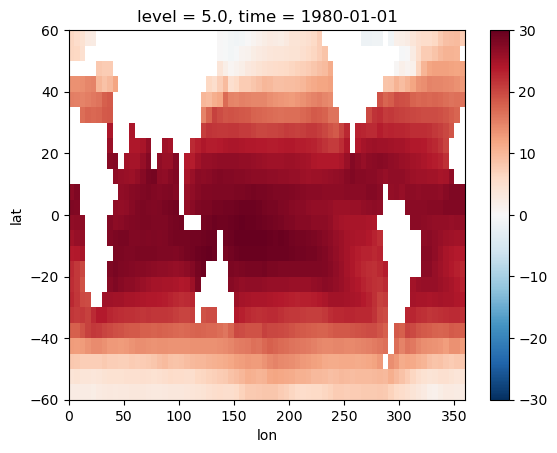

In [11]:
GODAS_DATA_regrid[0, 0].plot()

In [12]:
target_grid = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-57.5, 60, 5)),
        "lon": (["lon"], np.arange(2.5, 360, 5)),
    }
)
target_grid["mask"] = xr.where(
    ~np.isnan(GODAS_DATA_regrid.isel(time=0, level=0, drop=True)), 1, 0
).load()
target_grid.to_netcdf(TARGET_GRID_PATH)
target_grid

<xarray.Dataset>
Dimensions:  (lat: 24, lon: 72)
Coordinates:
  * lat      (lat) float64 -57.5 -52.5 -47.5 -42.5 -37.5 ... 42.5 47.5 52.5 57.5
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
Data variables:
    mask     (lat, lon) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1

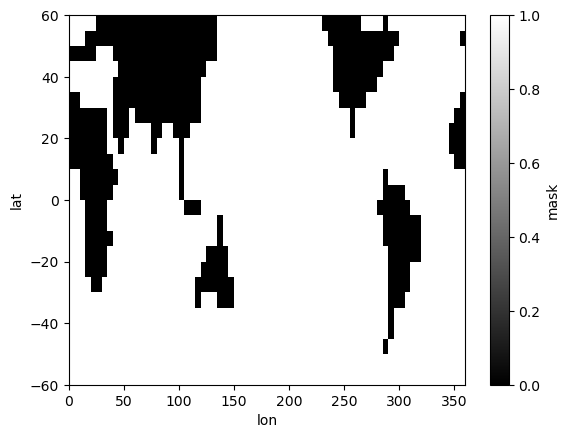

In [13]:
target_grid.mask.plot(cmap="binary_r")

## Sea Surface Temperature

Now that we have our data regridded, we can start subsetting and preprocessing the variables we will need.

The SST will be taken as the first level of the GODAS dataset.

In [14]:
GODAS_SST = GODAS_DATA_regrid.isel(level=0, drop=True).astype(np.float32)
GODAS_SST.name = "sst"
GODAS_SST.attrs["units"] = "degC"
GODAS_SST.attrs["long_name"] = "GODAS SST"
GODAS_SST

<xarray.DataArray 'sst' (time: 523, lat: 24, lon: 72)>
array([[[ 2.417405  ,  2.3570218 ,  2.355666  , ...,  2.6492581 ,
          2.5446472 ,  2.4906807 ],
        [ 4.193102  ,  4.2230625 ,  3.9755602 , ...,  4.420084  ,
          3.9441469 ,  4.110822  ],
        [ 7.987892  ,  7.848639  ,  7.4839892 , ...,  7.6761394 ,
          8.049223  ,  8.19949   ],
        ...,
        [        nan,         nan,         nan, ..., 12.061181  ,
         11.754012  , 11.982759  ],
        [ 6.4086814 ,  6.166671  ,  4.8964896 , ..., 10.378261  ,
         10.231737  ,         nan],
        [ 6.527694  ,  5.3949156 ,  4.625723  , ...,  9.167377  ,
          9.444161  ,  7.5242763 ]],

       [[ 2.1949067 ,  2.198008  ,  2.377853  , ...,  2.8451986 ,
          2.6645405 ,  2.4866023 ],
        [ 3.9547944 ,  3.9655254 ,  3.9601114 , ...,  4.771246  ,
          4.1081605 ,  4.1563277 ],
        [ 8.040739  ,  7.716913  ,  7.4428096 , ...,  8.302567  ,
          8.527393  ,  8.526399  ],
...
        [        nan,         nan,         nan, ..., 17.162773  ,
         17.628136  , 19.700724  ],
        [14.205659  , 15.225419  , 14.677296  , ..., 15.88994   ,
         16.250574  ,         nan],
        [13.214704  , 14.533018  , 16.031103  , ..., 13.436617  ,
         13.420282  , 12.684361  ]],

       [[-1.5365638 , -1.6488668 , -1.5918221 , ..., -0.7335693 ,
         -0.96682996, -1.3272396 ],
        [ 1.1553729 ,  1.2161969 ,  0.9756883 , ...,  1.7489337 ,
          0.802384  ,  0.923703  ],
        [ 6.01252   ,  5.5595603 ,  5.143369  , ...,  5.011601  ,
          5.615396  ,  5.8369465 ],
        ...,
        [        nan,         nan,         nan, ..., 17.812445  ,
         18.591244  , 20.268303  ],
        [16.037626  , 17.146523  , 17.012903  , ..., 15.797263  ,
         16.524275  ,         nan],
        [15.037461  , 16.017954  , 16.587534  , ..., 14.0125    ,
         14.200016  , 14.019815  ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-07-01
  * lat      (lat) float64 -57.5 -52.5 -47.5 -42.5 -37.5 ... 42.5 47.5 52.5 57.5
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
Attributes:
    regrid_method:  conservative_normed
    units:          degC
    long_name:      GODAS SST

In [15]:
GODAS_SST_ds = GODAS_SST.to_dataset()
GODAS_SST_ds["mask"] = target_grid.mask
GODAS_SST_ds

<xarray.Dataset>
Dimensions:  (time: 523, lat: 24, lon: 72)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-07-01
  * lat      (lat) float64 -57.5 -52.5 -47.5 -42.5 -37.5 ... 42.5 47.5 52.5 57.5
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
Data variables:
    sst      (time, lat, lon) float32 2.417 2.357 2.356 ... 14.01 14.2 14.02
    mask     (lat, lon) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1

In [16]:
GODAS_SST_ds.to_netcdf(os.path.join(DATA_PATH, "processed", "godas.sst.nc"))

## Sea Surface Height

In [17]:
GODAS_SSH = (
    xr.open_mfdataset(os.path.join(DATA_PATH, "raw", "GODAS", "sshg*.nc")).sshg * 100
)
GODAS_SSH

<xarray.DataArray 'sshg' (time: 522, lat: 418, lon: 360)>
dask.array<mul, shape=(522, 418, 360), dtype=float32, chunksize=(12, 418, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -74.5 -74.17 -73.83 -73.5 ... 63.5 63.83 64.17 64.5
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-06-01

In [19]:
regridder = xe.Regridder(
    source_grid,
    target_grid,
    "conservative_normed",
)

GODAS_SSH_regrid = (
    regridder(GODAS_SSH).load().interpolate_na(dim="time").interpolate_na(dim="lon")
).where(target_grid.mask == 1)
GODAS_SSH_regrid

<xarray.DataArray (time: 523, lat: 24, lon: 72)>
array([[[-165.82027 , -167.10515 , -168.0217  , ..., -160.77844 ,
         -162.10126 , -161.99377 ],
        [-130.02951 , -124.587265, -121.6998  , ..., -130.37785 ,
         -139.96318 , -135.28876 ],
        [ -64.56938 ,  -57.693085,  -54.428474, ..., -105.01022 ,
          -85.72069 ,  -65.8908  ],
        ...,
        [        nan,         nan,         nan, ...,  -44.519085,
          -42.16433 ,  -39.749928],
        [ -59.18937 ,  -57.537476,  -55.230446, ...,  -50.845642,
          -43.813477,         nan],
        [ -51.53656 ,  -57.435867,  -53.69253 , ...,  -58.590496,
          -52.540897,  -52.588024]],

       [[-162.05176 , -165.84007 , -164.77545 , ..., -155.4343  ,
         -156.68375 , -157.62758 ],
        [-126.96684 , -121.5745  , -118.56329 , ..., -127.143074,
         -136.64864 , -132.00374 ],
        [ -62.45524 ,  -55.39373 ,  -53.555706, ..., -101.76798 ,
          -82.80704 ,  -63.779575],
...
        [        nan,         nan,         nan, ...,  -36.91473 ,
          -36.362442,  -34.290897],
        [ -41.238583,  -43.224346,  -43.67377 , ...,  -42.089207,
          -38.933594,         nan],
        [ -41.562416,  -40.608376,  -44.87088 , ...,  -49.120056,
          -47.524303,  -48.119846]],

       [[-170.29057 , -174.40436 , -178.2661  , ..., -160.13713 ,
         -162.17213 , -164.47429 ],
        [-134.83856 , -131.17505 , -132.07816 , ..., -130.16278 ,
         -140.16846 , -138.3526  ],
        [ -68.688286,  -67.408615,  -67.87609 , ..., -103.88238 ,
          -87.85732 ,  -72.28694 ],
        ...,
        [        nan,         nan,         nan, ...,  -36.815968,
          -35.489323,  -33.69192 ],
        [ -40.56244 ,  -39.942833,  -37.018974, ...,  -43.336975,
          -38.46125 ,         nan],
        [ -44.463707,  -42.070904,  -38.934296, ...,  -49.52639 ,
          -47.25726 ,  -48.375427]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-07-01
  * lat      (lat) float64 -57.5 -52.5 -47.5 -42.5 -37.5 ... 42.5 47.5 52.5 57.5
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
Attributes:
    regrid_method:  conservative_normed

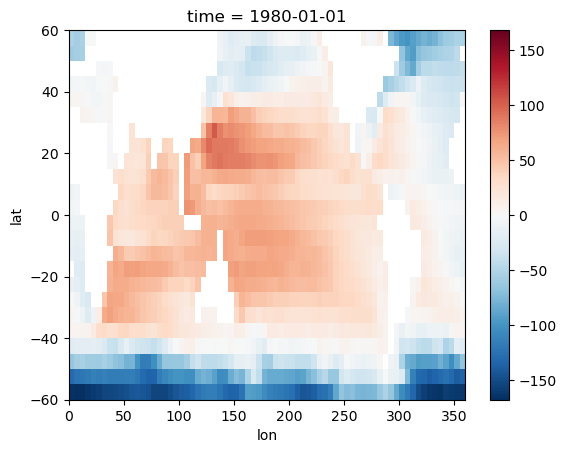

In [20]:
GODAS_SSH_regrid.isel(time=0).plot()

In [21]:
GODAS_SSH_regrid_ds = GODAS_SSH_regrid.to_dataset(name="ssh")
GODAS_SSH_regrid_ds["mask"] = target_grid.mask

In [22]:
GODAS_SSH_regrid_ds.to_netcdf(os.path.join(DATA_PATH, "processed", "godas.ssh.nc"))

## NCEP-DOE Reanalysis 2

These are the winds that force the GODAS runs. We will use the 10m winds. https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis2/Monthlies/gaussian_grid/

In [23]:
NCEP_Uwind = xr.open_dataset(
    os.path.join(DATA_PATH, "raw", "NCEP", "uwnd.10m.mon.mean.nc")
).uwnd.isel(level=0, drop=True)
NCEP_Uwind

<xarray.DataArray 'uwnd' (time: 535, lat: 94, lon: 192)>
[9655680 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-07-01
Attributes: (12/14)
    long_name:      Monthly Mean of Forecast of U-wind at 10 m
    units:          m/s
    precision:      2
    GRIB_id:        33
    GRIB_name:      U GRD
    var_desc:       u-wind
    ...             ...
    statistic:      Individual Obs
    parent_stat:    Other
    standard_name:  eastward_wind
    cell_methods:   time: mean (monthly of 6-hourly values)
    valid_range:    [-120.  120.]
    actual_range:   [-20.339996  17.740005]

In [24]:
NCEP_Vwind = xr.open_dataset(
    os.path.join(DATA_PATH, "raw", "NCEP", "vwnd.10m.mon.mean.nc")
).vwnd.isel(level=0, drop=True)
NCEP_Vwind

<xarray.DataArray 'vwnd' (time: 535, lat: 94, lon: 192)>
[9655680 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-07-01
Attributes: (12/14)
    long_name:      Monthly Mean of Forecast of V-wind at 10 m
    units:          m/s
    precision:      2
    GRIB_id:        34
    GRIB_name:      V GRD
    var_desc:       v-wind
    ...             ...
    statistic:      Individual Obs
    parent_stat:    Other
    standard_name:  northward_wind
    cell_methods:   time: mean (monthly of 6-hourly values)
    valid_range:    [-120.  120.]
    actual_range:   [-18.449997  20.800003]

In [25]:
SOURCE_GRID_PATH = os.path.join(DATA_PATH, "processed", "ncep.source.grid.94x192.nc")
check_folder(os.path.dirname(SOURCE_GRID_PATH))
source_grid = xr.Dataset(
    {
        "lat": (["lat"], NCEP_Uwind.lat.data),
        "lon": (["lon"], NCEP_Uwind.lon.data),
    }
)
source_grid["mask"] = xr.where(
    ~np.isnan(NCEP_Uwind.isel(time=0, drop=True).load()), 1, 0
)
source_grid.to_netcdf(SOURCE_GRID_PATH)
source_grid

<xarray.Dataset>
Dimensions:  (lat: 94, lon: 192)
Coordinates:
  * lat      (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Data variables:
    mask     (lat, lon) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1

In [26]:
REGRIDDER_PATH = os.path.join(DATA_PATH, "processed", "ncep.regridder.nc")
check_folder(os.path.dirname(REGRIDDER_PATH))

regridder_ncep = xe.Regridder(
    source_grid,
    target_grid,
    "conservative_normed",
)
target_grid.close()
regridder_ncep.to_netcdf(REGRIDDER_PATH)
regridder_ncep

xESMF Regridder 
Regridding algorithm:       conservative_normed 
Weight filename:            conservative_normed_94x192_24x72.nc 
Reuse pre-computed weights? False 
Input grid shape:           (94, 192) 
Output grid shape:          (24, 72) 
Periodic in longitude?      False

In [27]:
NCEP_Uwind_regrid = regridder_ncep(NCEP_Uwind).interpolate_na(dim="time")
NCEP_Vwind_regrid = regridder_ncep(NCEP_Vwind).interpolate_na(dim="time")

NCEP_Uwind_regrid_ds = NCEP_Uwind_regrid.to_dataset(name="uwnd")
NCEP_Uwind_regrid_ds["mask"] = target_grid.mask

NCEP_Vwind_regrid_ds = NCEP_Vwind_regrid.to_dataset(name="vwnd")
NCEP_Vwind_regrid_ds["mask"] = target_grid.mask

NCEP_Uwind_regrid_ds.to_netcdf(os.path.join(DATA_PATH, "processed", "ncep.uwnd.nc"))
NCEP_Vwind_regrid_ds.to_netcdf(os.path.join(DATA_PATH, "processed", "ncep.vwnd.nc"))

### Climatology

The climatology is computed as a mean per month of a defined climatological period.

In [28]:
GODAS_CLIM = clim(
    GODAS_DATA_regrid.isel(level=0, drop=True), slice("1991", "2020")
).astype(np.float32)
GODAS_CLIM.name = "sst_clim"
GODAS_CLIM.attrs["period"] = "Climatology GODAS 1991-2020"
GODAS_CLIM.attrs["units"] = "degC"
GODAS_CLIM.attrs["long_name"] = "GODAS SST Monthly Climatology"
GODAS_CLIM

<xarray.DataArray 'sst_clim' (month: 12, lat: 24, lon: 72)>
array([[[ 1.5892032 ,  1.6315746 ,  1.6912506 , ...,  1.9632043 ,
          1.7783844 ,  1.6491905 ],
        [ 3.270629  ,  3.3732948 ,  3.2585502 , ...,  3.8075166 ,
          3.198027  ,  3.2249062 ],
        [ 7.0425158 ,  6.9331794 ,  6.8973093 , ...,  7.084539  ,
          7.4212437 ,  7.3359    ],
        ...,
        [        nan,         nan,         nan, ..., 12.298004  ,
         12.0766535 , 12.420773  ],
        [ 7.0980563 ,  6.7755117 ,  5.946661  , ..., 10.955146  ,
         10.785252  ,         nan],
        [ 7.0420547 ,  6.3198295 ,  5.614742  , ...,  9.697     ,
          9.839366  ,  7.7768927 ]],

       [[ 1.8912508 ,  2.0061858 ,  2.1335554 , ...,  2.3399274 ,
          2.1320045 ,  1.9522833 ],
        [ 3.5123167 ,  3.6116304 ,  3.4893882 , ...,  4.099832  ,
          3.4404101 ,  3.4461389 ],
        [ 7.3664336 ,  7.2268167 ,  7.12645   , ...,  7.4480767 ,
          7.749121  ,  7.6095853 ],
...
        [        nan,         nan,         nan, ..., 14.397062  ,
         14.287768  , 15.068812  ],
        [10.888427  , 11.467895  , 11.393207  , ..., 12.491072  ,
         12.7846365 ,         nan],
        [ 9.770918  , 10.378194  , 10.434915  , ..., 10.869721  ,
         11.215445  ,  9.869076  ]],

       [[ 0.37004775,  0.26520318,  0.2451906 , ...,  0.8596944 ,
          0.6652032 ,  0.51962274],
        [ 2.5484884 ,  2.646857  ,  2.5192716 , ...,  2.9982574 ,
          2.3993137 ,  2.462666  ],
        [ 6.3511095 ,  6.2530375 ,  6.224279  , ...,  6.3225636 ,
          6.729602  ,  6.717954  ],
        ...,
        [        nan,         nan,         nan, ..., 13.084381  ,
         12.873471  , 13.364456  ],
        [ 8.58264   ,  8.75086   ,  8.344715  , ..., 11.480897  ,
         11.486001  ,         nan],
        [ 8.085196  ,  7.9906926 ,  7.663098  , ..., 10.104105  ,
         10.327363  ,  8.602192  ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -57.5 -52.5 -47.5 -42.5 -37.5 ... 42.5 47.5 52.5 57.5
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    regrid_method:  conservative_normed
    period:         Climatology GODAS 1991-2020
    units:          degC
    long_name:      GODAS SST Monthly Climatology

In [29]:
GODAS_CLIM_ds = GODAS_CLIM.to_dataset()
GODAS_CLIM_ds["mask"] = target_grid.mask
GODAS_CLIM_ds.to_netcdf(os.path.join(DATA_PATH, "processed", "godas.sst.clim.nc"))

In [30]:
GODAS_SSH_CLIM = clim(GODAS_SSH_regrid, slice("1991", "2020")).astype(np.float32)
GODAS_SSH_CLIM.name = "ssh_clim"
GODAS_SSH_CLIM.attrs["period"] = "Climatology SSH 1991-2020"
GODAS_SSH_CLIM.attrs["units"] = "cm"
GODAS_SSH_CLIM.attrs["long_name"] = "GODAS SSH Monthh Climatology"
GODAS_SSH_CLIM

<xarray.DataArray 'ssh_clim' (month: 12, lat: 24, lon: 72)>
array([[[-167.95285 , -169.59613 , -167.95876 , ..., -160.07753 ,
         -162.18623 , -163.1264  ],
        [-134.08963 , -126.702194, -124.44123 , ..., -130.38121 ,
         -143.7709  , -141.81953 ],
        [ -68.31437 ,  -63.60299 ,  -62.437847, ..., -105.517105,
          -86.09991 ,  -68.735504],
        ...,
        [        nan,         nan,         nan, ...,  -41.95792 ,
          -38.998062,  -36.503803],
        [ -45.354572,  -41.646927,  -36.13466 , ...,  -47.088146,
          -39.880672,         nan],
        [ -43.20797 ,  -42.542126,  -35.46031 , ...,  -54.67297 ,
          -47.709114,  -46.142056]],

       [[-168.20131 , -171.69856 , -169.66562 , ..., -159.1787  ,
         -161.39696 , -162.82065 ],
        [-133.31377 , -126.146736, -124.19334 , ..., -129.47784 ,
         -143.20088 , -141.27858 ],
        [ -67.273056,  -62.446274,  -60.842052, ..., -105.0819  ,
          -85.428474,  -68.007706],
...
        [        nan,         nan,         nan, ...,  -38.999027,
          -36.1402  ,  -33.441185],
        [ -44.283535,  -40.55935 ,  -35.78095 , ...,  -43.996677,
          -37.482895,         nan],
        [ -42.81039 ,  -43.297825,  -35.359276, ...,  -51.340206,
          -44.911602,  -44.20784 ]],

       [[-168.11388 , -170.11002 , -167.88728 , ..., -158.85286 ,
         -162.28271 , -162.13626 ],
        [-132.69478 , -126.20242 , -123.53724 , ..., -129.43365 ,
         -141.92227 , -139.36656 ],
        [ -67.70894 ,  -63.055622,  -62.531536, ..., -105.299995,
          -85.16355 ,  -67.410805],
        ...,
        [        nan,         nan,         nan, ...,  -40.77049 ,
          -37.772533,  -35.273983],
        [ -44.208763,  -40.010475,  -34.594723, ...,  -45.580986,
          -38.78235 ,         nan],
        [ -42.69978 ,  -41.987904,  -34.135365, ...,  -52.651474,
          -46.23925 ,  -44.741497]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -57.5 -52.5 -47.5 -42.5 -37.5 ... 42.5 47.5 52.5 57.5
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    regrid_method:  conservative_normed
    period:         Climatology SSH 1991-2020
    units:          cm
    long_name:      GODAS SSH Monthh Climatology

In [31]:
GODAS_SSH_CLIM_ds = GODAS_SSH_CLIM.to_dataset()
GODAS_SSH_CLIM_ds["mask"] = target_grid.mask
GODAS_SSH_CLIM_ds.to_netcdf(os.path.join(DATA_PATH, "processed", "godas.ssh.clim.nc"))

In [32]:
NCEP_Uwind_CLIM = clim(NCEP_Uwind_regrid, slice("1991", "2020")).astype(np.float32)
NCEP_Uwind_CLIM.name = "uwnd_clim"
NCEP_Uwind_CLIM.attrs["period"] = "Climatology NCEP 1991-2020"
NCEP_Uwind_CLIM.attrs["units"] = "m/s"
NCEP_Uwind_CLIM.attrs["long_name"] = "NCEP Uwind Monthly Climatology"
NCEP_Uwind_CLIM

<xarray.DataArray 'uwnd_clim' (month: 12, lat: 24, lon: 72)>
array([[[5.140645  , 5.178906  , 5.29061   , ..., 4.5219393 ,
         4.8162985 , 5.021396  ],
        [8.41513   , 8.430537  , 8.220886  , ..., 7.4568524 ,
         7.717362  , 8.147333  ],
        [9.435994  , 9.260211  , 9.080194  , ..., 8.495485  ,
         8.774809  , 9.274512  ],
        ...,
        [       nan,        nan,        nan, ..., 4.3259935 ,
         3.6770155 , 2.416448  ],
        [3.6152143 , 3.0420923 , 3.204558  , ..., 5.111488  ,
         3.6374567 ,        nan],
        [4.0144157 , 1.880077  , 1.9127241 , ..., 4.780256  ,
         4.2515035 , 4.301588  ]],

       [[6.457826  , 6.4628143 , 6.557341  , ..., 6.073687  ,
         6.2222753 , 6.356222  ],
        [9.373568  , 9.389365  , 9.148148  , ..., 8.430823  ,
         8.674002  , 9.119419  ],
        [9.354284  , 9.300623  , 9.18318   , ..., 8.277126  ,
         8.571097  , 9.106756  ],
...
        [       nan,        nan,        nan, ..., 4.137574  ,
         3.4582965 , 2.1164353 ],
        [2.7082274 , 1.9182538 , 1.9455955 , ..., 4.557005  ,
         3.0253022 ,        nan],
        [2.3471441 , 0.45668617, 0.60397184, ..., 3.5390708 ,
         2.8751078 , 2.6991487 ]],

       [[5.6055055 , 5.5260873 , 5.5044627 , ..., 5.2050233 ,
         5.3980546 , 5.548789  ],
        [8.329217  , 8.497233  , 8.392184  , ..., 7.3539457 ,
         7.5545325 , 7.9740987 ],
        [8.892346  , 8.925351  , 8.954956  , ..., 7.5133367 ,
         7.9170527 , 8.561204  ],
        ...,
        [       nan,        nan,        nan, ..., 3.6204944 ,
         3.3577323 , 2.3856611 ],
        [3.513431  , 2.9213538 , 3.1432397 , ..., 4.283822  ,
         3.3026822 ,        nan],
        [3.874474  , 1.8709677 , 1.8695537 , ..., 4.019315  ,
         3.6748416 , 3.8931334 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -57.5 -52.5 -47.5 -42.5 -37.5 ... 42.5 47.5 52.5 57.5
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    regrid_method:  conservative_normed
    period:         Climatology NCEP 1991-2020
    units:          m/s
    long_name:      NCEP Uwind Monthly Climatology

In [33]:
NCEP_Vwind_CLIM = clim(NCEP_Vwind_regrid, slice("1991", "2020")).astype(np.float32)
NCEP_Vwind_CLIM.name = "vwnd_clim"
NCEP_Vwind_CLIM.attrs["period"] = "Climatology NCEP 1991-2020"
NCEP_Vwind_CLIM.attrs["units"] = "m/s"
NCEP_Vwind_CLIM.attrs["long_name"] = "NCEP Vwind Monthly Climatology"
NCEP_Vwind_CLIM

<xarray.DataArray 'vwnd_clim' (month: 12, lat: 24, lon: 72)>
array([[[-2.8047153e-01, -8.6571926e-01, -1.4996438e+00, ...,
          6.0930889e-02,  1.0445070e-01, -2.6226591e-03],
        [-1.7254932e+00, -2.3010037e+00, -2.8362184e+00, ...,
         -1.5896611e+00, -1.7084041e+00, -1.5892692e+00],
        [-2.2199516e+00, -2.5052304e+00, -2.6544828e+00, ...,
         -2.4090025e+00, -2.4081187e+00, -2.1669126e+00],
        ...,
        [           nan,            nan,            nan, ...,
          2.4723690e+00,  1.9248028e+00,  1.9536115e+00],
        [ 3.2337034e+00,  3.4199121e+00,  2.6979423e+00, ...,
          4.3138256e+00,  3.9233046e+00,            nan],
        [ 3.7244315e+00,  3.1010413e+00,  1.8420360e+00, ...,
          4.3640232e+00,  4.9724188e+00,  4.2627749e+00]],

       [[-3.8267341e-01, -1.1230115e+00, -2.0269754e+00, ...,
          9.7118288e-02,  6.7763194e-02, -6.5236405e-02],
        [-1.7966181e+00, -2.5887094e+00, -3.5081191e+00, ...,
         -1.2740726e+00, -1.6521596e+00, -1.6148020e+00],
        [-2.0986578e+00, -2.7486765e+00, -3.0963247e+00, ...,
         -1.7698057e+00, -1.9203184e+00, -1.7937731e+00],
...
        [           nan,            nan,            nan, ...,
          3.1904480e-01,  6.3138586e-01,  1.3555877e+00],
        [ 2.8137662e+00,  3.2839425e+00,  2.7182896e+00, ...,
          1.9930058e+00,  2.4291863e+00,            nan],
        [ 3.0270884e+00,  2.7896733e+00,  1.7251681e+00, ...,
          2.2324755e+00,  3.2644622e+00,  3.0743711e+00]],

       [[-8.2012182e-01, -1.1678884e+00, -1.6420254e+00, ...,
         -7.6317751e-01, -8.3430392e-01, -7.8571993e-01],
        [-1.9492877e+00, -2.3600678e+00, -2.7651222e+00, ...,
         -1.9783385e+00, -2.1077323e+00, -1.9540893e+00],
        [-2.6090939e+00, -2.7566614e+00, -2.5678446e+00, ...,
         -2.5237820e+00, -2.6750183e+00, -2.5883851e+00],
        ...,
        [           nan,            nan,            nan, ...,
          2.5160234e+00,  1.8828607e+00,  1.8358295e+00],
        [ 2.8692791e+00,  3.4913194e+00,  3.0387104e+00, ...,
          3.7770238e+00,  3.4277139e+00,            nan],
        [ 2.9245770e+00,  2.6360025e+00,  1.7267303e+00, ...,
          3.6274488e+00,  4.0900507e+00,  3.4388325e+00]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -57.5 -52.5 -47.5 -42.5 -37.5 ... 42.5 47.5 52.5 57.5
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    regrid_method:  conservative_normed
    period:         Climatology NCEP 1991-2020
    units:          m/s
    long_name:      NCEP Vwind Monthly Climatology

In [34]:
NCEP_Uwind_CLIM_ds = NCEP_Uwind_CLIM.to_dataset()
NCEP_Uwind_CLIM_ds["mask"] = target_grid.mask
NCEP_Uwind_CLIM_ds.to_netcdf(os.path.join(DATA_PATH, "processed", "ncep.uwnd.clim.nc"))

NCEP_Vwind_CLIM_ds = NCEP_Vwind_CLIM.to_dataset()
NCEP_Vwind_CLIM_ds["mask"] = target_grid.mask
NCEP_Vwind_CLIM_ds.to_netcdf(os.path.join(DATA_PATH, "processed", "ncep.vwnd.clim.nc"))

### Anomalies

SST anomalies are just the difference between the SST and the climatology.

In [35]:
GODAS_SST_ANOM = (
    (GODAS_DATA_regrid.isel(level=0, drop=True).groupby("time.month") - GODAS_CLIM)
    .drop("month")
    .astype(np.float32)
)
GODAS_SST_ANOM.name = "ssta"
GODAS_SST_ANOM.attrs["period"] = "Climatology GODAS 1991-2020"
GODAS_SST_ANOM.attrs["units"] = "degC"
GODAS_SST_ANOM.attrs["long_name"] = "GODAS SST Anomaly"
GODAS_SST_ANOM

<xarray.DataArray 'ssta' (time: 523, lat: 24, lon: 72)>
array([[[ 0.82820165,  0.7254472 ,  0.66441536, ...,  0.6860539 ,
          0.76626277,  0.84149015],
        [ 0.92247295,  0.8497677 ,  0.71701   , ...,  0.6125674 ,
          0.74612   ,  0.885916  ],
        [ 0.9453764 ,  0.91545963,  0.58667994, ...,  0.5916004 ,
          0.6279793 ,  0.86358976],
        ...,
        [        nan,         nan,         nan, ..., -0.23682308,
         -0.32264137, -0.43801308],
        [-0.6893749 , -0.60884094, -1.0501714 , ..., -0.5768852 ,
         -0.5535145 ,         nan],
        [-0.5143604 , -0.9249139 , -0.9890189 , ..., -0.5296221 ,
         -0.39520454, -0.2526164 ]],

       [[ 0.30365586,  0.19182229,  0.2442975 , ...,  0.5052712 ,
          0.53253603,  0.53431904],
        [ 0.4424777 ,  0.35389495,  0.47072315, ...,  0.6714139 ,
          0.66775036,  0.71018887],
        [ 0.67430544,  0.49009657,  0.31635952, ...,  0.8544898 ,
          0.77827215,  0.9168134 ],
...
        [        nan,         nan,         nan, ...,  1.7684383 ,
          1.9769669 ,  2.5670643 ],
        [ 0.9010868 ,  1.4643412 ,  1.7880592 , ...,  2.1691456 ,
          2.1657495 ,         nan],
        [ 1.0273256 ,  1.3472643 ,  2.2899237 , ...,  1.3771448 ,
          1.3714857 ,  1.1377239 ]],

       [[-0.08013582, -0.10030329, -0.19923234, ...,  0.01606023,
         -0.0494476 , -0.1792388 ],
        [-0.11529565, -0.27175665, -0.4224407 , ...,  0.40920794,
          0.09715331, -0.03720003],
        [ 0.6521201 ,  0.1313529 , -0.13040638, ...,  0.58377314,
          0.08120394,  0.01347876],
        ...,
        [        nan,         nan,         nan, ...,  0.5576706 ,
          0.96305656,  1.0668888 ],
        [ 0.13901806,  0.5747471 ,  0.7683697 , ...,  0.5575943 ,
          0.6157408 ,         nan],
        [ 0.3499651 ,  0.11697769, -0.08042336, ...,  0.67950535,
          0.700861  ,  0.4377947 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-07-01
  * lat      (lat) float64 -57.5 -52.5 -47.5 -42.5 -37.5 ... 42.5 47.5 52.5 57.5
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
Attributes:
    period:     Climatology GODAS 1991-2020
    units:      degC
    long_name:  GODAS SST Anomaly

In [36]:
GODAS_SST_ANOM_ds = GODAS_SST_ANOM.to_dataset()
GODAS_SST_ANOM_ds["mask"] = target_grid.mask
GODAS_SST_ANOM_ds.to_netcdf(os.path.join(DATA_PATH, "processed", "godas.sst.anom.nc"))

In [37]:
GODAS_SSH_ANOM = (
    (GODAS_SSH_regrid.groupby("time.month") - GODAS_SSH_CLIM)
    .drop("month")
    .astype(np.float32)
)
GODAS_SSH_ANOM.name = "sla"
GODAS_SSH_ANOM.attrs["period"] = "Climatology GODAS 1991-2020"
GODAS_SSH_ANOM.attrs["units"] = "cm"
GODAS_SSH_ANOM.attrs["long_name"] = "GODAS SSH Anomaly"
GODAS_SSH_ANOM

<xarray.DataArray 'sla' (time: 523, lat: 24, lon: 72)>
array([[[ 2.1325836e+00,  2.4909821e+00, -6.2942505e-02, ...,
         -7.0091248e-01,  8.4976196e-02,  1.1326294e+00],
        [ 4.0601196e+00,  2.1149292e+00,  2.7414322e+00, ...,
          3.3569336e-03,  3.8077240e+00,  6.5307770e+00],
        [ 3.7449875e+00,  5.9099045e+00,  8.0093727e+00, ...,
          5.0688171e-01,  3.7921906e-01,  2.8447037e+00],
        ...,
        [           nan,            nan,            nan, ...,
         -2.5611649e+00, -3.1662674e+00, -3.2461243e+00],
        [-1.3834797e+01, -1.5890549e+01, -1.9095787e+01, ...,
         -3.7574959e+00, -3.9328041e+00,            nan],
        [-8.3285904e+00, -1.4893742e+01, -1.8232220e+01, ...,
         -3.9175262e+00, -4.8317833e+00, -6.4459686e+00]],

       [[ 6.1495514e+00,  5.8584900e+00,  4.8901672e+00, ...,
          3.7444000e+00,  4.7132111e+00,  5.1930695e+00],
        [ 6.3469238e+00,  4.5722351e+00,  5.6300430e+00, ...,
          2.3347702e+00,  6.5522461e+00,  9.2748413e+00],
        [ 4.8178177e+00,  7.0525436e+00,  7.2863464e+00, ...,
          3.3139191e+00,  2.6214371e+00,  4.2281303e+00],
...
        [           nan,            nan,            nan, ...,
          4.4342842e+00,  2.9620171e+00,  2.7358818e+00],
        [ 5.5331497e+00,  2.7507248e+00, -7.6126862e-01, ...,
          5.3418922e+00,  2.9137917e+00,            nan],
        [ 5.6161308e+00,  5.1825829e+00, -5.0049973e-01, ...,
          5.5095329e+00,  2.9818954e+00,  2.8332787e+00]],

       [[ 4.9425507e+00,  4.8944244e+00, -1.5096893e+00, ...,
          4.4195557e+00,  4.8390808e+00,  3.5112152e+00],
        [ 2.9638519e+00, -4.5326233e-01, -3.0459747e+00, ...,
          4.6250000e+00,  7.2032318e+00,  6.6342773e+00],
        [ 3.6284027e+00, -6.9401550e-01, -4.2423401e+00, ...,
          6.2128601e+00,  1.4345322e+00, -8.4527588e-01],
        ...,
        [           nan,            nan,            nan, ...,
          2.4261055e+00,  1.7822876e+00,  1.4418602e+00],
        [ 3.9814034e+00,  3.4300880e+00,  2.9316635e+00, ...,
          2.2451706e+00,  1.5077057e+00,            nan],
        [ 1.0352974e+00,  1.8975220e+00,  3.2717819e+00, ...,
          3.3080025e+00,  1.3153534e+00,  5.8730698e-01]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-07-01
  * lat      (lat) float64 -57.5 -52.5 -47.5 -42.5 -37.5 ... 42.5 47.5 52.5 57.5
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
Attributes:
    period:     Climatology GODAS 1991-2020
    units:      cm
    long_name:  GODAS SSH Anomaly

In [38]:
GODAS_SSH_ANOM_ds = GODAS_SSH_ANOM.to_dataset()
GODAS_SSH_ANOM_ds["mask"] = target_grid.mask
GODAS_SSH_ANOM_ds.to_netcdf(os.path.join(DATA_PATH, "processed", "godas.ssh.anom.nc"))

In [39]:
NCEP_Uwind_ANOM = (
    (
        NCEP_Uwind_regrid.groupby("time.month")
        - clim(NCEP_Uwind_regrid, slice("1991", "2020"))
    )
    .drop("month")
    .astype(np.float32)
)
NCEP_Uwind_ANOM.name = "uwnda"
NCEP_Uwind_ANOM.attrs["period"] = "Climatology NCEP 1991-2020"
NCEP_Uwind_ANOM.attrs["units"] = "m/s"
NCEP_Uwind_ANOM.attrs["long_name"] = "NCEP Uwind Anomaly"
NCEP_Uwind_ANOM

<xarray.DataArray 'uwnda' (time: 535, lat: 24, lon: 72)>
array([[[ 0.6307616 ,  0.42122602,  0.05427027, ..., -0.68885374,
         -0.32057428,  0.3329339 ],
        [-0.16160774, -0.07340908,  0.1746273 , ..., -0.19706964,
         -0.42255878, -0.42506886],
        [-1.4803643 , -0.64665985,  0.5092144 , ..., -0.8966584 ,
         -1.24048   , -1.6302223 ],
        ...,
        [        nan,         nan,         nan, ..., -2.4400096 ,
         -3.1536582 , -3.629292  ],
        [-2.962633  , -2.3434308 , -1.473764  , ..., -3.970066  ,
         -3.5787046 ,         nan],
        [-3.566279  , -4.0368676 , -3.2062082 , ..., -2.7085671 ,
         -3.1958866 , -2.6129496 ]],

       [[-0.32612133,  0.2843852 ,  0.44586658, ..., -3.2540836 ,
         -2.3097665 , -1.254859  ],
        [-4.1468596 , -3.2204518 , -2.2424655 , ..., -4.801549  ,
         -5.0341334 , -4.867992  ],
        [-2.2196093 , -1.4816704 , -0.5772791 , ..., -2.6620936 ,
         -2.3890977 , -2.4669623 ],
...
        [        nan,         nan,         nan, ..., -2.168047  ,
         -2.681446  , -2.4894881 ],
        [-3.3723285 , -2.7141273 , -2.3306556 , ..., -2.5758083 ,
         -2.8662488 ,         nan],
        [-1.8856992 , -1.6004806 , -1.9166514 , ..., -1.8071098 ,
         -2.2640305 , -2.2081027 ]],

       [[ 1.5937967 ,  1.481472  ,  1.1134157 , ...,  1.2087965 ,
          1.3191347 ,  1.6729503 ],
        [-0.03637218,  0.5992689 ,  1.1561995 , ..., -1.4410253 ,
         -1.0641165 , -0.6590414 ],
        [-0.98854494, -0.20658016,  0.26113224, ..., -3.3514485 ,
         -2.7662492 , -1.8822227 ],
        ...,
        [        nan,         nan,         nan, ...,  3.150913  ,
          3.4191625 ,  2.2039654 ],
        [ 2.2600482 ,  1.6146008 ,  1.2300318 , ...,  1.6921349 ,
          1.684763  ,         nan],
        [ 1.5724368 ,  1.7035811 ,  1.4323058 , ..., -1.8410015 ,
         -1.3645576 ,  0.05506015]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-07-01
  * lat      (lat) float64 -57.5 -52.5 -47.5 -42.5 -37.5 ... 42.5 47.5 52.5 57.5
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
Attributes:
    period:     Climatology NCEP 1991-2020
    units:      m/s
    long_name:  NCEP Uwind Anomaly

In [40]:
NCEP_Vwind_ANOM = (
    (
        NCEP_Vwind_regrid.groupby("time.month")
        - clim(NCEP_Vwind_regrid, slice("1991", "2020"))
    )
    .drop("month")
    .astype(np.float32)
)
NCEP_Vwind_ANOM.name = "vwnda"
NCEP_Vwind_ANOM.attrs["period"] = "Climatology NCEP 1991-2020"
NCEP_Vwind_ANOM.attrs["units"] = "m/s"
NCEP_Vwind_ANOM.attrs["long_name"] = "NCEP Vwind Anomaly"
NCEP_Vwind_ANOM

<xarray.DataArray 'vwnda' (time: 535, lat: 24, lon: 72)>
array([[[ 0.77172244,  1.1709098 ,  2.118572  , ..., -1.7330028 ,
         -1.1067823 ,  0.11795455],
        [ 1.3904164 ,  2.3926156 ,  2.921411  , ..., -1.2658582 ,
         -0.6353471 ,  0.35588133],
        [ 1.9043425 ,  2.0990005 ,  1.8792961 , ..., -0.59666157,
          0.275537  ,  1.3033447 ],
        ...,
        [        nan,         nan,         nan, ..., -4.2933607 ,
         -2.673815  , -0.49952698],
        [-1.3759308 , -1.1393812 , -1.7184212 , ..., -6.0298095 ,
         -3.1331868 ,         nan],
        [-1.0041237 , -1.078778  , -2.6173525 , ..., -6.6440935 ,
         -4.284148  , -2.5759683 ]],

       [[ 2.2634788 ,  2.6797233 ,  3.0256438 , ..., -0.21626203,
          0.8532184 ,  1.7908622 ],
        [ 2.1964207 ,  2.8706834 ,  3.255128  , ...,  1.3137702 ,
          1.8438329 ,  1.997569  ],
        [ 0.5765512 ,  1.337891  ,  1.292797  , ...,  0.5275606 ,
          0.21812606,  0.16899264],
...
        [        nan,         nan,         nan, ...,  1.3772243 ,
          0.40091226, -0.776052  ],
        [-1.8845326 , -1.7260702 , -1.1712276 , ...,  0.814654  ,
          1.1561503 ,         nan],
        [-0.07390914, -0.8885827 , -0.45268205, ...,  0.5037794 ,
          1.7465569 ,  1.6435382 ]],

       [[ 0.85545075,  1.6109909 ,  2.3060138 , ...,  0.02767342,
         -0.12196159,  0.28662464],
        [ 0.8518388 ,  1.2790618 ,  1.9229219 , ..., -1.0960848 ,
         -0.3452543 ,  0.41719466],
        [-0.05479228,  0.9743241 ,  2.2905161 , ..., -0.8744751 ,
         -0.1929605 , -0.29548657],
        ...,
        [        nan,         nan,         nan, ...,  1.452782  ,
          2.3992743 ,  2.2410057 ],
        [ 2.3830223 ,  2.199725  ,  1.682116  , ..., -0.9056591 ,
          1.3769103 ,         nan],
        [ 0.49127454,  1.6428255 ,  2.3870492 , ..., -2.9560988 ,
         -1.8126192 , -0.31176442]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-07-01
  * lat      (lat) float64 -57.5 -52.5 -47.5 -42.5 -37.5 ... 42.5 47.5 52.5 57.5
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
Attributes:
    period:     Climatology NCEP 1991-2020
    units:      m/s
    long_name:  NCEP Vwind Anomaly

In [41]:
NCEP_Uwind_ANOM_ds = NCEP_Uwind_ANOM.to_dataset()
NCEP_Uwind_ANOM_ds["mask"] = target_grid.mask
NCEP_Uwind_ANOM_ds.to_netcdf(os.path.join(DATA_PATH, "processed", "ncep.uwnd.anom.nc"))

NCEP_Vwind_ANOM_ds = NCEP_Vwind_ANOM.to_dataset()
NCEP_Vwind_ANOM_ds["mask"] = target_grid.mask
NCEP_Vwind_ANOM_ds.to_netcdf(os.path.join(DATA_PATH, "processed", "ncep.vwnd.anom.nc"))